This notebook inverts a coherence-weighted velocity/disp rate for each pixel over a few different time periods, including skip1 AND skip2 igrams.   

This notebook: <br>
1. loads in FILT, unwrapped igrams for a row at a time
2. references each igram to a topo-corrected ref pixel phase average value 
3. Inverts for average velocity with coherence as weights, covariance matrix guided by synthetic tests I did by converting Rowena's MATLAB code. Incorporating skip1+skip2 igrams also.

NOTE: This network with bandwidth 3 ONLY WORKS with filtered igrams. With unfiltered igrams, the skip1 and skip2 igrams are redundant and won't add any information unless there are unwrapping errors. <br><br>

This notebook was copied and edited on 5-25-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

# Need this function to convert datetime objects to decimal years. Got this off of stackexchange. 
def datetime2year(dt): 
    year_part = dt - datetime(year=dt.year, month=1, day=1)
    year_length = (
        datetime(year=dt.year + 1, month=1, day=1)
        - datetime(year=dt.year, month=1, day=1)
    )
    return dt.year + year_part / year_length

Do we want to run this notebook with filtered/unfiltered data? <br>
What about referenced to average phase value, reference box, or reference pixels chosen by "chooseing_reference_pixels.ipynb"

In [2]:
# choose one: 'filt' or 'unfilt'
key1 = 'filt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

Grab dates of SLCs/igrams and calculate number of SLCs (nd) and igrams (numIgrams).

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
# dx = 3000
# dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); 
# numIgrams = nd-1
# numSkip1Igrams = numIgrams - 1
print(str(nd)+' SLCs.')

211 SLCs.


Load the intind (interferogram indices) array to know which igrams we'll be using.

In [4]:
# Read in intid 
intid = np.loadtxt('/data/ocp4/LagunaSalada/Data_and_Figs/1_igrams/network_bw3.txt', dtype='int')
numIgrams = np.shape(intid)[0]
print(str(numIgrams)+' igrams.\n')
print('SLC1 \tSLC2')

for i in range(numIgrams): 
    print(str(intid[i,0])+'\t'+str(intid[i,1]))

627 igrams.

SLC1 	SLC2
0	1
0	2
0	3
1	2
1	3
1	4
2	3
2	4
2	5
3	4
3	5
3	6
4	5
4	6
4	7
5	6
5	7
5	8
6	7
6	8
6	9
7	8
7	9
7	10
8	9
8	10
8	11
9	10
9	11
9	12
10	11
10	12
10	13
11	12
11	13
11	14
12	13
12	14
12	15
13	14
13	15
13	16
14	15
14	16
14	17
15	16
15	17
15	18
16	17
16	18
16	19
17	18
17	19
17	20
18	19
18	20
18	21
19	20
19	21
19	22
20	21
20	22
20	23
21	22
21	23
21	24
22	23
22	24
22	25
23	24
23	25
23	26
24	25
24	26
24	27
25	26
25	27
25	28
26	27
26	28
26	29
27	28
27	29
27	30
28	29
28	30
28	31
29	30
29	31
29	32
30	31
30	32
30	33
31	32
31	33
31	34
32	33
32	34
32	35
33	34
33	35
33	36
34	35
34	36
34	37
35	36
35	37
35	38
36	37
36	38
36	39
37	38
37	39
37	40
38	39
38	40
38	41
39	40
39	41
39	42
40	41
40	42
40	43
41	42
41	43
41	44
42	43
42	44
42	45
43	44
43	45
43	46
44	45
44	46
44	47
45	46
45	47
45	48
46	47
46	48
46	49
47	48
47	49
47	50
48	49
48	50
48	51
49	50
49	51
49	52
50	51
50	52
50	53
51	52
51	53
51	54
52	53
52	54
52	55
53	54
53	55
53	56
54	55
54	56
54	57
55	56
55	57
55	58
56	57
56	58
56	59
57	5

In [5]:
print((nd-1)+(nd-2)+(nd-3))

627


Load in the mask for reference pixels chosen with a few criteria. 

In [6]:
# load reference pixels mask 
#maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

# filter size for calculating average reference pixels phase value for each igram.
alooks=4*4
rlooks=20*4
# filter it to use for reference pixel phase calculation.
ref_mask_filt = gaussian_filter(ref_mask,sigma = [alooks/2,rlooks/2])

Reference pixel mask loaded.


Load each igram, calculate the elevation vs. phase relationship (slope and intercept) for points with elevation over a threshold (capturing mostly just bedrock), save those values for each igram.

In [7]:
slopes = np.ndarray((numIgrams,),dtype='float')
intercepts = np.ndarray((numIgrams,),dtype='float')

elev_cutoff = 150

#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'

# load the DEM
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
print('DEM loaded.')

for i in range(numIgrams):
    date1 = dates[intid[i,0]]
    date2 = dates[intid[i,1]]
    igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # add condition that elevations over 125 m (relationship applies best for bedrock/high elevations)
    phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
    els = elev.flatten()[(elev.flatten() > elev_cutoff)]
    m, b = np.polyfit(els,phs,1)
    slopes[i] = m
    intercepts[i] = b
    print('SLC1: '+str(intid[i,0])+'\t\tSLC2: '+str(intid[i,1])+'\t\tslope: '+str('%0.3f' % m)+' rad/m,  intercept: '+str('%0.3f' % b)+' rad.')
print('done.')

DEM loaded.
SLC1: 0		SLC2: 1		slope: 0.012 rad/m,  intercept: 0.613 rad.
SLC1: 0		SLC2: 2		slope: 0.011 rad/m,  intercept: 6.280 rad.
SLC1: 0		SLC2: 3		slope: 0.015 rad/m,  intercept: 4.249 rad.
SLC1: 1		SLC2: 2		slope: -0.001 rad/m,  intercept: 5.663 rad.
SLC1: 1		SLC2: 3		slope: 0.003 rad/m,  intercept: 3.624 rad.
SLC1: 1		SLC2: 4		slope: 0.003 rad/m,  intercept: 8.425 rad.
SLC1: 2		SLC2: 3		slope: 0.004 rad/m,  intercept: 4.241 rad.
SLC1: 2		SLC2: 4		slope: 0.004 rad/m,  intercept: 9.039 rad.
SLC1: 2		SLC2: 5		slope: -0.024 rad/m,  intercept: 8.135 rad.
SLC1: 3		SLC2: 4		slope: -0.000 rad/m,  intercept: 4.806 rad.
SLC1: 3		SLC2: 5		slope: -0.028 rad/m,  intercept: 3.892 rad.
SLC1: 3		SLC2: 6		slope: -0.023 rad/m,  intercept: -3.430 rad.
SLC1: 4		SLC2: 5		slope: -0.028 rad/m,  intercept: 5.375 rad.
SLC1: 4		SLC2: 6		slope: -0.023 rad/m,  intercept: -1.943 rad.
SLC1: 4		SLC2: 7		slope: -0.018 rad/m,  intercept: 0.494 rad.
SLC1: 5		SLC2: 6		slope: 0.005 rad/m,  intercept: -7.320 rad.
S

Plot mask file to be sure I'm using the right ref pix.

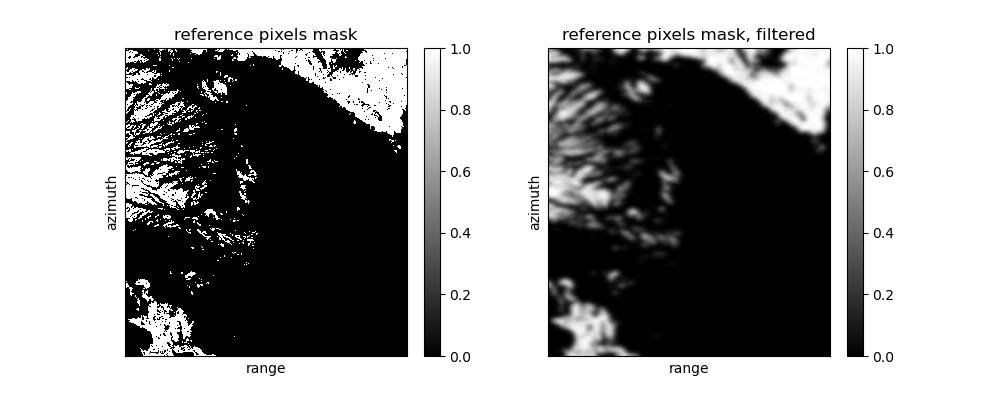

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(ref_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(ref_mask_filt, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask, filtered') 
plt.colorbar(); plt.show()

Read in each unfilt, unwrapped igram and calculate the average phase value over all reference pixels and save it into array. <br><br>

This takes ~12 min to run. 

In [9]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
avg_ref_vals = np.ndarray((numIgrams,),dtype='float')
# ignore the divide-by-zero error messages that pop up in each loop iteration.
np.seterr(divide='ignore', invalid='ignore')

elev_min = min(elev.flatten())
# igramsDir is where the cropped, unwrapped igrams are
#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
for i in range(numIgrams): # numIgrams if doing all of them at once
    date1 = dates[intid[i,0]]
    date2 = dates[intid[i,1]]
    igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # remove the topography effects
    temp_igram = temp_igram - (elev-elev_min)*slopes[i] # + intercepts[i]
    # Now mask the igram based on ref pixels and filter it.
    igram_masked = np.zeros((dy,dx))
    igram_masked[mask_y,mask_x] = temp_igram[mask_y,mask_x]
    igram_filt = gaussian_filter(igram_masked,sigma = [alooks/2,rlooks/2])
    ab = igram_filt / ref_mask_filt
    avg_ref_vals[i] = np.nanmean(ab) 
    print('SLC1: '+str(intid[i,0])+'\t\tSLC2: '+str(intid[i,1])+'\t\tavg_ref_val: '+str('%.4f' % avg_ref_vals[i]))
print('Avg value of ref pixels calculated for all '+key1+' igrams.')
# save space/RAM and clean up these variables now. 
del igramFile, ds, temp_igram

SLC1: 0		SLC2: 1		avg_ref_val: 0.8545
SLC1: 0		SLC2: 2		avg_ref_val: 6.5604
SLC1: 0		SLC2: 3		avg_ref_val: 4.0980
SLC1: 1		SLC2: 2		avg_ref_val: 5.7041
SLC1: 1		SLC2: 3		avg_ref_val: 3.2296
SLC1: 1		SLC2: 4		avg_ref_val: 6.9830
SLC1: 2		SLC2: 3		avg_ref_val: 3.8082
SLC1: 2		SLC2: 4		avg_ref_val: 7.5569
SLC1: 2		SLC2: 5		avg_ref_val: 7.7595
SLC1: 3		SLC2: 4		avg_ref_val: 3.7521
SLC1: 3		SLC2: 5		avg_ref_val: 3.9542
SLC1: 3		SLC2: 6		avg_ref_val: -2.3543
SLC1: 4		SLC2: 5		avg_ref_val: 6.4829
SLC1: 4		SLC2: 6		avg_ref_val: 0.1789
SLC1: 4		SLC2: 7		avg_ref_val: 3.8545
SLC1: 5		SLC2: 6		avg_ref_val: -6.3060
SLC1: 5		SLC2: 7		avg_ref_val: 3.6608
SLC1: 5		SLC2: 8		avg_ref_val: -4.4019
SLC1: 6		SLC2: 7		avg_ref_val: 9.9673
SLC1: 6		SLC2: 8		avg_ref_val: 1.9073
SLC1: 6		SLC2: 9		avg_ref_val: 7.2535
SLC1: 7		SLC2: 8		avg_ref_val: -1.7792
SLC1: 7		SLC2: 9		avg_ref_val: -2.7099
SLC1: 7		SLC2: 10		avg_ref_val: -1.3801
SLC1: 8		SLC2: 9		avg_ref_val: 5.3453
SLC1: 8		SLC2: 10		avg_ref_val: 6.6770
SLC1

Pull out SLC dates.

In [ ]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# convert to floats 
slc_dates_floats = np.ndarray((len(slc_dates),1),dtype='float')
for i in range(len(slc_dates)):
    slc_dates_floats[i] = datetime2year(slc_dates[i]) # now an array of floats in years
print('slc_dates: '+str(np.shape(slc_dates)[0]))

Pull out interferogram dates.

In [ ]:
# loop through intid and pull out date of second SLC (for plotting purposes)
igram_dates_SLC2=[]
dt_days = np.ndarray((numIgrams,),dtype='float')
for i in range(numIgrams):
    date1 = dates[intid[i,0]]    # First SLC 
    date2 = dates[intid[i,1]]    # Second SLC 
    igram_dates_SLC2.append(datetime.strptime(str(date2).replace('\n',''), '%Y%m%d'))
    dt_temp = slc_dates[intid[i,1]] - slc_dates[intid[i,0]] # this is in timedelta format now
    #print(dt_temp)
    dt_days[i] = dt_temp.days
print('igram_dates_SLC2: '+str(np.shape(igram_dates_SLC2)[0]))

Make sure the average reference phase value lines up with the data.

In [ ]:
print('Avg ref value: '+str(np.mean(avg_ref_vals)))
plt.figure(figsize=(6,3),tight_layout=True)
plt.axhline(np.mean(avg_ref_vals),linestyle=':',color='k')
plt.plot(igram_dates_SLC2,avg_ref_vals,'b.')
plt.ylabel('Ref phase value (rad)')
plt.show()

Find which dates I need to separate the time series into to fit slopes for each pixel.

In [ ]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,nd-1,88,nd-1,153] # nd-1 is the last index of SLCs 
num_intervals = len(start_indices)

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]]+' - '+str(dates[end_indices[i]])))
print('\ntotal duration of this study: '+str((igram_dates_SLC2[-1]-igram_dates_SLC2[0]).days/365.25)+' years')

This is the old version. Keeping it here for reference for time being.

In [ ]:
driver=gdal.GetDriverByName('ISCE')
# if testing with a large disp value with bad coherence, set this key to 'test'
key = 'notest'
# which interval?
j = 5
# choose an y,x coordinate, which pixel? 
y = dy-2
x = 100
#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
# cohDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
#saveDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'

# pick out indices from the interval (interval j)
interval_length = end_indices[j]-start_indices[j]
print(str(interval_length)+' dates in interval '+str(j)+'.')
# set up temp arrays for the row I'm extracting each time 
temp_phs = np.ndarray((interval_length,),dtype='float')
temp_coh = np.ndarray((interval_length,),dtype='float')
# load in phase values for single pixel, correct them (subtract avg ref value), load coherences for that row of pix
for i in range(interval_length):
    #print(start_indices[j]+i)
    date1 = dates[start_indices[j]+i]
    date2 = dates[start_indices[j]+i+1]
    igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    # only reading in one row at a time 
    temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)     # (startx,starty,dx,dy)  
    # correct for topography 
    temp_phs[i] = temp_phs[i] - (elev[y,x]-elev_min)*slopes[i] # + intercepts[i])
    # correct based on avg ref values and topography correction
    temp_phs[i] = temp_phs[i] - avg_ref_vals[start_indices[j]+i]
    # load one line of coherence files
    cohFile = 'coh_'+date1+'-'+date2+'.r4'
    ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
    # only reading in one row at a time
    temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)
# times of SLCs in interval j
t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting
# this is date-related/atmospheric noise (instead of coherence/std.dev.s/variances which are speckle/igram-related)
noise_diags = np.ones(interval_length)*1.0                  # ones on diagonal 
noise_off_diags = np.ones(interval_length-1)*(-0.5)         # -0.5 on off diagonals
# date/atm-related noise covariance matrix
covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1) \
    +np.diag(noise_off_diags,1) 
# coherence at that pixel over the interval, use this to calc variance.
coh_at_pixel = temp_coh                                     # all dates, just the one pixel 
variances = (-2*np.log(coh_at_pixel))                       # got this formula from Rowena's cor_sigma_test.m file 
if key=='test':
    # OPTIONAL: make the Nth variance a HUGE number to test 
    variances[20] = 100.0
vars_diag = np.diag(variances,0)
# Combine date-related and igram-related noise into proper covariance matrix 
covi2 = covi + vars_diag                                    # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
icov = np.linalg.inv(covi2)                                 # inverse of covariance matrix
# Make d(data) matrix (change in displacement over each igram, referenced to avg value over entire igram)
disps = np.copy(temp_phs)                                            # this is disp over igrams in interval, for the single pixel  
if key=='test':
    # OPTIONAL: make the Nth disp a HUGE number to test 
    disps[20] = -10.0
# Calculate cumulative displacement to do simple polyfit for comparison with weighted fit.
cum_disps = np.hstack((0,np.cumsum(disps)))
# make G matrix with 1's and -1's 
G_diags = np.ones((interval_length-1))
Gint = np.diag(G_diags,1)-1*np.eye(interval_length)         # -1's along diagonal, 1's on upper off diagonal
# plot covariance matrices 
plt.figure(figsize=(9,3),tight_layout='TRUE')    
plt.subplot(1,3,1); plt.imshow(covi,interpolation='nearest',vmin=-0.5,vmax=1.6)
plt.colorbar(); plt.title('covi \n(igram-related noise)')
plt.subplot(1,3,2); plt.imshow(covi2,interpolation='nearest',vmin=-0.5,vmax=1.6)
plt.colorbar(); plt.title('covi2 \n(igram + date-related noise)')
plt.subplot(1,3,3); plt.imshow(covi2-covi,interpolation='nearest')
plt.colorbar(); plt.title('covi2 - covi'); plt.show() 
# calculate dt's (time intervals of each igram)
dt = np.diff(t.T)[0]                                        # the indices are weird from diff, the [0] index is actually the array we want.
# do inversion 
# USING DISP RATE (disp per igram) AND DT
G_disps = dt.reshape((interval_length,1))
Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
model_disp_rates = Gg_disps_weighted.dot(disps)             # weighted inversion directly from ints 
vel_disp_rate = model_disp_rates[0]                         # this just gives a velocity, no intercept 
# calculate a line from the weighted inversion for velocity, set intercept to zero.
line = vel_disp_rate*(t-t[0]) + 0.0
# make a conversion factor from radians to cm. 
wavelength = 5.5465763                                      # C-band, in cm 
rad2cm = wavelength/(4*np.pi)                               # this is conversion factor that I multiply by the data (which is in rads)
# a normal linear regression (to make sure weighted version is different)
m, b = np.polyfit(t.reshape((interval_length+1,)),cum_disps,1)
line_nonweighted = m*t+b
# plot cumulative displacements over the interval, colored by coherence. 
plt.figure(figsize=(10,4),tight_layout='TRUE')
plt.plot(t_datetime,cum_disps,'k-'); plt.ylabel('rad')
plt.scatter(t_datetime[1::],cum_disps[1::],c=coh_at_pixel,label='coherence')
# need soemthing to align weighted disp rate with unweighted disp rate lines
offset = np.mean(line)-np.mean(line_nonweighted)
# plot the nonweighted vs. weighted fit lines 
plt.plot(t_datetime,line-offset,'g-',label='weighted fit vel. from disp rates')
plt.plot(t_datetime,line_nonweighted,'r-',label='nonweighted fit velocity')
plt.ylabel('cumulative disp (rad)'); plt.legend(); plt.colorbar(label='igram-related variance')
plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3)))
plt.show()
print('nonweighted velocity: \t\t'+str(m)+' rad/yr \t'+str(rad2cm*m)+' cm/yr')
#print('weighted velocity: \t\t'+str(vel_cum_disp)+' rad/yr \t'+str(rad2cm*vel_cum_disp)+' cm/yr')
print('weighted vel from disp rates: \t'+str(vel_disp_rate)+' rad/yr \t'+str(rad2cm*vel_disp_rate)+' cm/yr')
rmse = np.std(disps-vel_disp_rate)
print('RMSE to weighted fit: \t\t'+str(rmse)+' rad/yr \t'+str(rad2cm*rmse)+' cm/yr')

Make a "master" G matrix that I can slice into later

In [ ]:
# make G matrix with 1's and -1's FOR ALL THE IGRAMS/SLCS IN ENTIRE TIME PERIOD 
G = np.zeros((numIgrams,nd))
for i in range(numIgrams):
    #print(i,intid[i,0])
    G[i,intid[i,0]] = -1
    #print(i,intid[i,1])
    G[i,intid[i,1]] = 1
# plot G matrix 
plt.figure(figsize=(5,5),tight_layout='TRUE')   
plt.imshow(G,aspect='equal'); plt.colorbar()
plt.title('G matrix for all dates/igrams'); plt.show()

Do one pixel for one interval and plot the time series to check if the weighted inversion is working. 

In [ ]:
driver=gdal.GetDriverByName('ISCE')
# if testing with a large disp value with bad coherence, set this key to 'test'
key = 'notest'
# which interval?
j = 5
# choose an y,x coordinate, which pixel? 
y = dy-2
x = 100
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'
# how many SLCs are in the interval?
num_SLCs_subset = end_indices[j]-start_indices[j]+1
print(str(num_SLCs_subset)+' SLCs in this interval.')
# how many sequential igrams are in the interval? 
num_seq_igrams_subset = num_SLCs_subset - 1
print(str(num_seq_igrams_subset)+' sequential igrams in this interval.')
# how many igram combos are there in the interval? 
numIgrams_subset = (num_SLCs_subset-1)+(num_SLCs_subset-2)+(num_SLCs_subset-3)
print(str(numIgrams_subset)+' igrams in this interval.')
intid_subset = np.ndarray((numIgrams_subset,2),dtype='int')
avg_ref_vals_subset = np.ndarray((numIgrams_subset,),dtype='float')
count = 0
#print(start_indices[j],end_indices[j])
for i in range(numIgrams):
    #print(intid[i,0],intid[i,1])
    if start_indices[j] <= intid[i,0] and end_indices[j] >= intid[i,1]:
        #print('this igram is in the interval.')
        intid_subset[count,0] = intid[i,0]
        intid_subset[count,1] = intid[i,1]
        avg_ref_vals_subset[count] = avg_ref_vals[i]
        count = count+1
#print(np.shape(intid_subset))
# set up temp arrays for the pixel I'm extracting each time 
temp_phs = np.ndarray((numIgrams_subset,),dtype='float')
temp_phs_seq = np.ndarray((num_seq_igrams_subset,),dtype='float')
temp_coh = np.ndarray((numIgrams_subset,),dtype='float')
temp_coh_seq = np.ndarray((num_seq_igrams_subset,),dtype='float')
count = 0
# load in phase values for single pixel, correct them (subtract avg ref value), load coherences for that row of pix
for i in range(numIgrams_subset):
    #print(start_indices[j]+i)
    date1 = dates[intid_subset[i,0]]   # SLC1
    date2 = dates[intid_subset[i,1]]   # SLC2
    igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    # only reading in one row at a time 
    temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)     # (startx,starty,dx,dy)  
    # correct for topography 
    temp_phs[i] = temp_phs[i] - (elev[y,x]-elev_min)*slopes[i] # + intercepts[i])
    # correct based on avg ref values and topography correction

    # !!!!! CHECK THIS
    temp_phs[i] = temp_phs[i] - avg_ref_vals_subset[i]
    # !!!!! 

    # load one line of coherence files
    cohFile = 'coh_'+date1+'-'+date2+'.r4'
    ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
    # only reading in one row at a time
    temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)
    # if sequential, put in separate array for doing a cumulative disp plot for comparison 
    if intid_subset[i,0]+1 == intid_subset[i,1]:
        temp_phs_seq[count] = temp_phs[i]
        temp_coh_seq[count] = temp_coh[i]
        count = count+1
# times/dates of SLCs in interval j
t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting

# !!!!! 
# this is date-related/atmospheric noise (instead of coherence/std.dev.s/variances which are speckle/igram-related)
noise_diags = np.ones(numIgrams_subset)*1.0                  # ones on diagonal 
noise_off_diags = np.ones(numIgrams_subset-1)*(-0.5)         # -0.5 on off diagonals
# date/atm-related noise covariance matrix
covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1)+np.diag(noise_off_diags,1) 
# !!!!!

# coherence at that pixel over the interval, use this to calc variance.
coh_at_pixel = temp_coh                                     # all dates, just the one pixel 
variances = (-2*np.log(coh_at_pixel))                       # got this formula from Rowena's cor_sigma_test.m file 
if key=='test':
    # OPTIONAL: make the variance on the Nth igram a HUGE number to test 
    variances[20] = 100.0
vars_diag = np.diag(variances,0)
# Combine date-related and igram-related noise into proper covariance matrix 
covi2 = covi + vars_diag                                    # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
icov = np.linalg.inv(covi2)                                 # inverse of covariance matrix
# plot covariance matrices 
plt.figure(figsize=(9,3),tight_layout='TRUE')    
plt.subplot(1,3,1); plt.imshow(covi,interpolation='nearest',vmin=-0.5,vmax=1.6)
plt.colorbar(); plt.title('covi \n(igram-related noise)')
plt.subplot(1,3,2); plt.imshow(covi2,interpolation='nearest',vmin=-0.5,vmax=1.6)
plt.colorbar(); plt.title('covi2 \n(igram + date-related noise)')
plt.subplot(1,3,3); plt.imshow(covi2-covi,interpolation='nearest')
plt.colorbar(); plt.title('covi2 - covi'); plt.show() 

# Make d(data) matrix (change in displacement over each igram, referenced to avg value over entire igram)
disps = np.copy(temp_phs)                                            # this is disp over igrams in interval, for the single pixel  
if key=='test':
    # OPTIONAL: make the disp on the Nth igram a HUGE number to test 
    disps[20] = -30.0
    temp_phs_seq[20] = -30.0
# Calculate cumulative displacement to do simple polyfit for comparison with weighted fit.
# Can only use sequential here 
cum_disps = np.hstack((0,np.cumsum(temp_phs_seq)))
# Take a subsection of the master G matrix above.
G_subset = np.ndarray((numIgrams_subset,num_SLCs_subset),dtype='float')
# extract the columns that correspond with the SLCs in the interval 
G_cropped = G[:,start_indices[j]:end_indices[j]+1]
count = 0
for i in range(numIgrams):
    #print(intid[i,0],intid[i,1])
    if start_indices[j] <= intid[i,0] and end_indices[j] >= intid[i,1]:
        #print('this igram is in the interval.')
        G_subset[count,:] = G_cropped[i,:]
        count = count+1
# plot G_subset matrix 
plt.figure(figsize=(5,5),tight_layout='TRUE')   
plt.imshow(G_subset,aspect='equal'); plt.colorbar()
plt.title('G matrix for interval '+str(j)); plt.show()
# calculate dt's (time intervals of each igram)
dt = G_subset.dot(t)
G_disps = dt
# do the inversion 
Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
model_disp_rates = Gg_disps_weighted.dot(disps)             # weighted inversion directly from ints 
vel_disp_rate = model_disp_rates[0]                         # this just gives a velocity, no intercept 
# print('G subset: '+str(np.shape(G_subset)))
# print('t: '+str(np.shape(t)))
# print('dt: '+str(np.shape(dt)))
# print('icov: '+str(np.shape(icov)))
# for i in range(numIgrams_subset):
#     print('dt: '+str(dt[i]))
# calculate a line from the weighted inversion for velocity, set intercept to zero.
line = vel_disp_rate*(t-t[0]) + 0.0
# make a conversion factor from radians to cm. 
wavelength = 5.5465763                                      # C-band, in cm 
rad2cm = wavelength/(4*np.pi)                               # this is conversion factor that I multiply by the data (which is in rads)
# a normal linear regression (to make sure weighted version is different)
m, b = np.polyfit(t.reshape((num_SLCs_subset,)),cum_disps,1)
line_nonweighted = m*t+b
# plot cumulative displacements over the interval, colored by coherence. 
plt.figure(figsize=(10,4),tight_layout='TRUE')
plt.plot(t_datetime,cum_disps,'k-'); plt.ylabel('rad')
plt.scatter(t_datetime[1::],cum_disps[1::],c=temp_coh_seq,label='coherence')
# need something to align weighted disp rate with unweighted disp rate lines
offset = np.mean(line)-np.mean(line_nonweighted)
# plot the nonweighted vs. weighted fit lines 
plt.plot(t_datetime,line-offset,'g-',label='weighted fit vel. from disp rates')
plt.plot(t_datetime,line_nonweighted,'r-',label='nonweighted fit velocity')
plt.ylabel('cumulative disp (rad)'); plt.legend(); plt.colorbar(label='igram-related variance')
plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3)))
plt.show()
print('nonweighted velocity: \t\t'+str(m)+' rad/yr \t'+str(rad2cm*m)+' cm/yr')
#print('weighted velocity: \t\t'+str(vel_cum_disp)+' rad/yr \t'+str(rad2cm*vel_cum_disp)+' cm/yr')
print('weighted vel from disp rates: \t'+str(vel_disp_rate)+' rad/yr \t'+str(rad2cm*vel_disp_rate)+' cm/yr')
rmse = np.std(disps-vel_disp_rate)
print('RMSE to weighted fit: \t\t'+str(rmse)+' rad/yr \t'+str(rad2cm*rmse)+' cm/yr')

Do inversions for ALL pixels (during one time interval or multiple/all).

In [ ]:
driver=gdal.GetDriverByName('ISCE')

# set up final arrays of weighted velocities and RMSE/residual stds
disp_rates_weighted = np.ndarray((num_intervals,dy,dx),dtype='float') 
disp_rates_residual_std = np.ndarray((num_intervals,dy,dx),dtype='float')
# set directories 
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'
 
# loop through intervals 
for j in np.arange(0,1,1): #range(num_intervals), range(1) will just do the first interval 
    print('Using '+str(key1)+' igrams.')
    # how many SLCs are in the interval?
    num_SLCs_subset = end_indices[j]-start_indices[j]+1
    print(str(num_SLCs_subset)+' SLCs in this interval.')
    # how many sequential igrams are in the interval? 
    num_seq_igrams_subset = num_SLCs_subset - 1
    print(str(num_seq_igrams_subset)+' sequential igrams in this interval.')
    # how many igram combos are there in the interval? 
    numIgrams_subset = (num_SLCs_subset-1)+(num_SLCs_subset-2)+(num_SLCs_subset-3)
    print(str(numIgrams_subset)+' igrams in this interval.')
    
    intid_subset = np.ndarray((numIgrams_subset,2),dtype='int')
    avg_ref_vals_subset = np.ndarray((numIgrams_subset,),dtype='float')
    count = 0
    #pull out intids for this interval from ALL of the possible bw3 combinations
    for i in range(numIgrams):
        #print(intid[i,0],intid[i,1])
        if start_indices[j] <= intid[i,0] and end_indices[j] >= intid[i,1]:
            #print('this igram is in the interval.')
            intid_subset[count,0] = intid[i,0]
            intid_subset[count,1] = intid[i,1]
            avg_ref_vals_subset[count] = avg_ref_vals[i]
            count = count+1
    
    # this just needs to be done once per interval, it's the same for each row/pixel.
    # times/dates of SLCs in interval j
    t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
    t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting
    
    # !!!!! 
    # this is date-related/atmospheric noise (instead of coherence/std.dev.s/variances which are speckle/igram-related)
    noise_diags = np.ones(numIgrams_subset)*1.0                  # ones on diagonal 
    noise_off_diags = np.ones(numIgrams_subset-1)*(-0.5)         # -0.5 on off diagonals
    # date/atm-related noise covariance matrix
    covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1)+np.diag(noise_off_diags,1) 
    # !!!!!

    # this just needs to be done once per interval. 
    # Take a subsection of the master G matrix above.
    G_subset = np.ndarray((numIgrams_subset,num_SLCs_subset),dtype='float')
    # extract the columns that correspond with the SLCs in the interval 
    G_cropped = G[:,start_indices[j]:end_indices[j]+1]
    count = 0
    for i in range(numIgrams):
        #print(intid[i,0],intid[i,1])
        if start_indices[j] <= intid[i,0] and end_indices[j] >= intid[i,1]:
            #print('this igram is in the interval.')
            G_subset[count,:] = G_cropped[i,:]
            count = count+1

    # calculate dt's (time intervals of each igram)
    dt = G_subset.dot(t)
    G_disps = dt

    # set up temp arrays for the row I'm extracting each time 
    temp_phs =      np.ndarray((numIgrams_subset,dx),dtype='float')        # axis 0 is date/igram index, axis 1 is x coordinate
    temp_phs_seq =  np.ndarray((num_seq_igrams_subset,dx),dtype='float')
    temp_coh =      np.ndarray((numIgrams_subset,dx),dtype='float')
    temp_coh_seq =  np.ndarray((num_seq_igrams_subset,dx),dtype='float')
    
    # loop through rows 
    for y in range(dy):
        count = 0
        # load in phase values for the row, correct them (subtract avg ref value), load coherences for that row of pix
        for i in range(numIgrams_subset):
            #print(start_indices[j]+i)
            date1 = dates[intid_subset[i,0]]   # SLC1
            date2 = dates[intid_subset[i,1]]   # SLC2
            igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
            ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
            # only reading in one row at a time 
            temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1)     # (startx,starty,dx,dy)  
            # correct for topography 
            temp_phs[i] = temp_phs[i] - (elev[y,:]-elev_min)*slopes[i] # + intercepts[i])
            # correct based on avg ref values and topography correction

            # !!!!! check that this is right 
            temp_phs[i] = temp_phs[i] - avg_ref_vals_subset[i]
            # !!!!!
            
            # load one line of coherence files
            cohFile = 'coh_'+date1+'-'+date2+'.r4'
            ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
            # only reading in one row at a time
            temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1)

        # loop through pixels in that row and do weighted velocity inversion.
        for x in range(dx):   # dx for all pixels 

            # coherence at that pixel over the interval, use this to calc variance.
            coh_at_pixel = temp_coh[:,x]                                # all dates, just the one pixel 
            variances = (-2*np.log(coh_at_pixel))                       # got this formula from Rowena's cor_sigma_test.m file 
            
            vars_diag = np.diag(variances,0)
            # Combine date-related and igram-related noise into proper covariance matrix 
            covi2 = covi + vars_diag                                    # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
            icov = np.linalg.inv(covi2)                                 # inverse of covariance matrix

            disps = temp_phs[:,x]                                       # this is disp over igrams in interval, for the single pixel  
            
            # do the inversion 
            Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
            model_disp_rates = Gg_disps_weighted.dot(disps)             # weighted inversion directly from ints 
            vel_disp_rate = model_disp_rates[0]                         # this just gives a velocity, no intercept 
            
            disp_rates_weighted[j,y,x] = vel_disp_rate                  # leave it in radians! 
            disp_rates_residual_std[j,y,x] = np.std(disps-vel_disp_rate)

        # print an update if we've gotten through 100*n rows
        if(np.remainder(y,100)==0):
            print('Row '+str(y)+' weighted inversions done.')

    # now save the disp rate and rmse files
    fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
    errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'
    colds = driver.Create(saveDir+fileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_weighted[j])
    colds=None
    colds = driver.Create(saveDir+errorFileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_residual_std[j])
    colds=None
    print('weighted disp rates and std of residuals saved for interval '+str(j))
print('done!') 

^
Interval 0 took ~35 min. <br>
Interval 1 took 38 min. <br>
Interval 2 took 27 min. <br>
Interval 3 took ~30 maybe? min. <br>
Interval 4 took 40 min. <br>
Interval 5 took ~2.25 hr. <br>
Interval 6 took ?? min. <br>

Plot the weighted disp rate map.

In [ ]:
i = 3 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
#print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_weighted[i], aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

Load in disp rate map if haven't just run it. 

In [ ]:
driver=gdal.GetDriverByName('ISCE')

j = 1
fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'

saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'
disp_rates = np.ndarray((dy,dx),dtype='float') 
disp_rates_errors = np.ndarray((dy,dx),dtype='float') 

f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None

f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
disp_rates_errors = f1.ReadAsArray()
f1 = None

print('interval '+str(j)+' disp rate map + errors loaded.')

In [ ]:
i = 1 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
#print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates, aspect='auto', vmin=-2.0,vmax=2.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_errors, aspect='auto',\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()